# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [1]:
# importing libraries
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchaudio
import torchvision
import os
from torchvision import transforms, datasets
import numpy as np
import shutil
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [2]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [3]:
# gpu shananigans
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: True
Using device: cuda


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device ID
    device_id = torch.cuda.current_device()
    
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(device_id)
    
    # Get device properties
    device_properties = torch.cuda.get_device_properties(device_id)
    
    print(f"CUDA is available. Using GPU {device_id}: {gpu_name}")
    print(f"Device properties: {device_properties}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU 0: NVIDIA GeForce RTX 3060 Ti
Device properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Ti', major=8, minor=6, total_memory=8191MB, multi_processor_count=38)


In [5]:
# Define the data transforms (e.g., normalization, augmentation)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the dataset
data_dir = '/home/shirwee/documents/aps360-labs-2024/lab3/Lab3 Dataset/Lab3_Gestures_Summer'
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Create new directories for split data
base_dir = '/home/shirwee/documents/aps360-labs-2024/lab3/Lab3 Dataset/Lab3_Gestures_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to create class subdirectories
def create_class_subdirs(base_dir, classes):
    for cls in classes:
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

# Create subdirectories for each class
classes = dataset.classes
create_class_subdirs(train_dir, classes)
create_class_subdirs(val_dir, classes)
create_class_subdirs(test_dir, classes)

# Function to split dataset indices by class
def split_indices_by_class(dataset, train_ratio=0.7, val_ratio=0.15):
    class_indices = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    train_indices = []
    val_indices = []
    test_indices = []

    for label, indices in class_indices.items():
        np.random.seed(42)
        np.random.shuffle(indices)
        train_split = int(train_ratio * len(indices))
        val_split = int(val_ratio * len(indices))
        
        train_indices.extend(indices[:train_split])
        val_indices.extend(indices[train_split:train_split + val_split])
        test_indices.extend(indices[train_split + val_split:])
    
    return train_indices, val_indices, test_indices

# Split indices by class
train_indices, val_indices, test_indices = split_indices_by_class(dataset)

# Function to copy images to new directories
def copy_images(dataset, indices, target_dir):
    for idx in indices:
        img_path, label = dataset.samples[idx]
        label_name = dataset.classes[label]
        target_class_dir = os.path.join(target_dir, label_name)
        shutil.copy(img_path, target_class_dir)

# Copy images to respective directories
copy_images(dataset, train_indices, train_dir)
copy_images(dataset, val_indices, val_dir)
copy_images(dataset, test_indices, test_dir)

# Print the number of samples in each set
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")



Training samples: 1548
Validation samples: 330
Test samples: 341


In [25]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)

# Increase the number of workers in DataLoader
train_loader = DataLoader(train_dataset)
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))

class GestureCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(GestureCNN, self).__init__()

        self.name = "hand"
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output
        x = x.view(-1, 128 * 28 * 28)
        
        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x



Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Ti


In [9]:
# Instantiate the model
model = GestureCNN().to(device)
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [10]:
total_model = 0
for param in model.parameters():
    total_model += param.numel()
print(total_model)

51478601


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [11]:
# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
# Function to save model checkpoint
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

# Evaluation function
def evaluate(net, data_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.eval()
    total_err = 0.0
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            total_err += (preds != labels).sum().item()
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    err = total_err / total_samples
    loss = total_loss / total_samples
    return err, loss

def train_net(net, batch_size=32, learning_rate=0.001, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    torch.manual_seed(1000)
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # print(f"Inputs are on device: {inputs.device}")
            # print(f"Labels are on device: {labels.device}")
            optimizer.zero_grad()
            outputs = net(inputs)
            # print(f"Outputs are on device: {outputs.device}")
            loss = criterion(outputs, labels)
            loss.backward()
            # print(f"Loss is on device: {loss.device}")
            optimizer.step()
            
            preds = outputs.argmax(dim=1)
            total_train_err += (preds != labels).sum().item()
            total_train_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
        
        train_err[epoch] = total_train_err / total_samples
        train_loss[epoch] = total_train_loss / total_samples
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    
    # Write the train/validation loss/err into CSV files for plotting later
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [14]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [69]:
# Train the model
model = GestureCNN().to(device)
train_net(model, batch_size=32, learning_rate=0.001, num_epochs=25)

Epoch 1: Train err: 0.9000, Train loss: 4.6523 | Validation err: 0.8879, Validation loss: 2.1986
Epoch 2: Train err: 0.9800, Train loss: 2.2182 | Validation err: 0.8848, Validation loss: 2.1974
Epoch 3: Train err: 0.7600, Train loss: 2.6736 | Validation err: 0.8909, Validation loss: 2.2252
Epoch 4: Train err: 0.9000, Train loss: 2.1040 | Validation err: 0.8909, Validation loss: 3.2861
Epoch 5: Train err: 0.9200, Train loss: 2.6243 | Validation err: 0.8697, Validation loss: 2.9996
Epoch 6: Train err: 0.9400, Train loss: 2.3091 | Validation err: 0.8879, Validation loss: 2.1987
Epoch 7: Train err: 0.9200, Train loss: 2.2956 | Validation err: 0.8879, Validation loss: 2.1976
Epoch 8: Train err: 0.8800, Train loss: 2.1960 | Validation err: 0.8879, Validation loss: 2.1979
Epoch 9: Train err: 0.8800, Train loss: 2.1909 | Validation err: 0.8879, Validation loss: 2.1985
Epoch 10: Train err: 0.8600, Train loss: 2.1822 | Validation err: 0.8879, Validation loss: 2.1995
Epoch 11: Train err: 0.9000, 

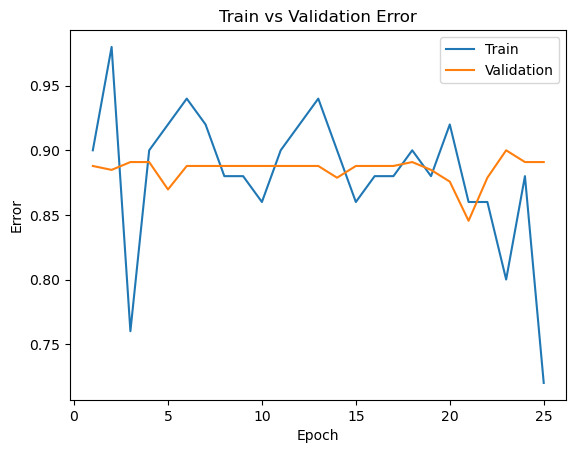

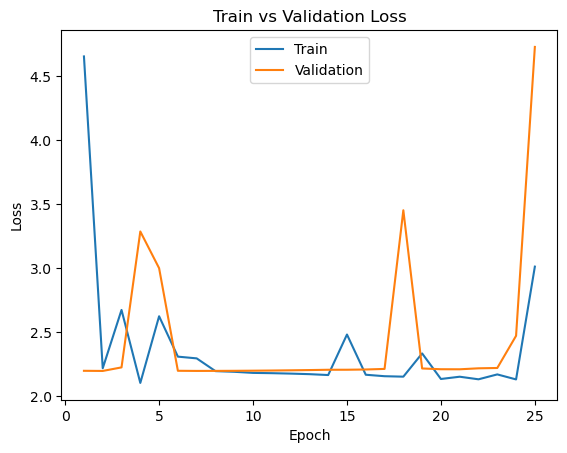

In [70]:

model_path = get_model_name("hand", batch_size=32, learning_rate=0.001, epoch=24)
plot_training_curve(model_path)


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [58]:
# Define the data transforms (e.g., normalization, augmentation)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

base_dir = '/home/shirwee/documents/aps360-labs-2024/lab3/Lab3 Dataset/Lab3_Gestures_Small_Split'
train_dir = os.path.join(base_dir, 'train')


os.makedirs(train_dir, exist_ok=True)

# Function to create class subdirectories
def create_class_subdirs(base_dir, classes):
    for cls in classes:
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

# Create subdirectories for each class
classes = dataset.classes
create_class_subdirs(train_dir, classes)

# Function to split dataset indices by class
def get_train_indices(dataset, num_samples=50):
    total_indices = list(range(len(dataset)))
    
    # Shuffle the total indices and select the first 20 samples
    np.random.seed(42)
    np.random.shuffle(total_indices)
    train_indices = total_indices[:num_samples]

    return train_indices

# Get training indices limited to 200 samples
train_indices = get_train_indices(dataset, num_samples=50)

# Function to copy images to new directories
def copy_images(dataset, indices, target_dir):
    for idx in indices:
        img_path, label = dataset.samples[idx]
        label_name = dataset.classes[label]
        target_class_dir = os.path.join(target_dir, label_name)
        shutil.copy(img_path, target_class_dir)

# Copy images to respective directories
copy_images(dataset, train_indices, train_dir)


# Print the number of samples in each set
print(f"Training samples: {len(train_indices)}")


Training samples: 50


In [67]:
# Load datasets
train_dataset_small = datasets.ImageFolder(root=train_dir, transform=data_transforms)


# Increase the number of workers in DataLoader
train_loader_small = DataLoader(train_dataset_small)


In [68]:
def train_net_small(net, batch_size=50, learning_rate=0.001, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    torch.manual_seed(1000)
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0
        
        for inputs, labels in train_loader_small:
            inputs, labels = inputs.to(device), labels.to(device)
            # print(f"Inputs are on device: {inputs.device}")
            # print(f"Labels are on device: {labels.device}")
            optimizer.zero_grad()
            outputs = net(inputs)
            # print(f"Outputs are on device: {outputs.device}")
            loss = criterion(outputs, labels)
            loss.backward()
            # print(f"Loss is on device: {loss.device}")
            optimizer.step()
            
            preds = outputs.argmax(dim=1)
            total_train_err += (preds != labels).sum().item()
            total_train_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
        
        train_err[epoch] = total_train_err / total_samples
        train_loss[epoch] = total_train_loss / total_samples
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    
    # Write the train/validation loss/err into CSV files for plotting later
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [65]:
model = GestureCNN().to(device)
train_net_small(model, batch_size=50, learning_rate=0.001, num_epochs=50)



NameError: name 'train_loader_small' is not defined

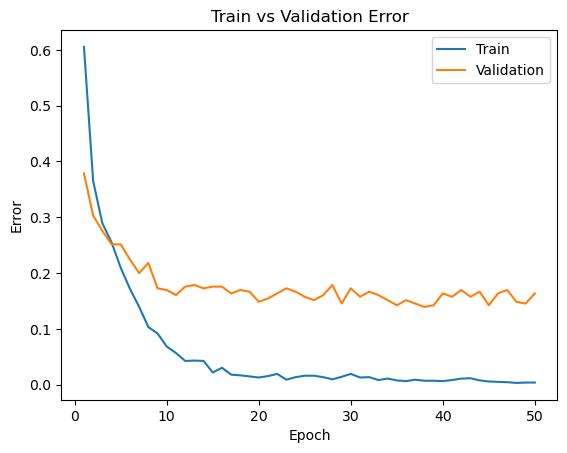

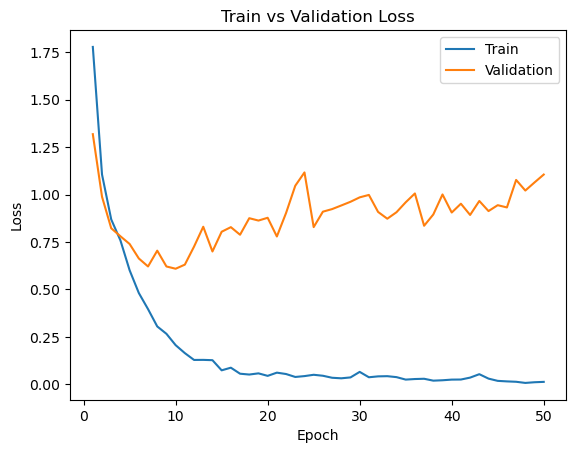

In [23]:
model_path = get_model_name("hand", batch_size=1548, learning_rate=0.001, epoch=49)
plot_training_curve(model_path)

In [27]:
train_error, train_loss = evaluate(model, train_loader, nn.CrossEntropyLoss())
print("Test Error：", train_error)
print("Test Loss: ", train_loss)

Test Error： 0.0006459948320413437
Test Loss:  0.0017975056329811452


### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

# Since there are severe signs of overfitting I will be trying to change the batch size number, learning rate, and number of hidden layers in the architecture

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [40]:
class Gesture_v1_CNN(nn.Module):
    def __init__(self, num_classes=9):
        super(Gesture_v1_CNN, self).__init__()

        self.name = "hidden_layers++"
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output
        x = x.view(-1, 128 * 28 * 28)
        
        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [42]:
model = Gesture_v1_CNN().to(device)
train_net(model, batch_size=100, learning_rate=0.001, num_epochs=10)

Epoch 1: Train err: 0.1344, Train loss: 2.3175 | Validation err: 0.8879, Validation loss: 3.3208
Epoch 2: Train err: 0.9115, Train loss: 2.3348 | Validation err: 0.8909, Validation loss: 2.2093
Epoch 3: Train err: 0.8844, Train loss: 2.2049 | Validation err: 0.8909, Validation loss: 2.2093
Epoch 4: Train err: 0.9063, Train loss: 2.2100 | Validation err: 0.8909, Validation loss: 2.2110
Epoch 5: Train err: 0.9205, Train loss: 2.2167 | Validation err: 0.8909, Validation loss: 2.2097
Epoch 6: Train err: 0.9180, Train loss: 2.2157 | Validation err: 0.8879, Validation loss: 2.2091
Epoch 7: Train err: 0.9199, Train loss: 2.2152 | Validation err: 0.8879, Validation loss: 2.2088
Epoch 8: Train err: 0.9218, Train loss: 2.2150 | Validation err: 0.8879, Validation loss: 2.2086
Epoch 9: Train err: 0.9225, Train loss: 2.2149 | Validation err: 0.8879, Validation loss: 2.2085
Epoch 10: Train err: 0.9231, Train loss: 2.2148 | Validation err: 0.8879, Validation loss: 2.2085
Finished Training
Total time 

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?